In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import chainer
from chainer.dataset import convert
import cv2
import net_conv

In [273]:
with open('../data/lifegame_data.pickle', 'rb') as f:
    d = pickle.load(f)
d[0] = np.array(list(map(lambda x: x.astype('float32'), d[0])))
with open('../data/lifegame_data_test.pickle', 'rb') as f:
    d_test = pickle.load(f)
d_test[0] = np.array(list(map(lambda x: x.astype('float32'), d_test[0])))
with open('../data/lifegame_data_glider.pickle', 'rb') as f:
    d_glider = pickle.load(f)
d_glider[0] = np.array(list(map(lambda x: x.astype('float32'), d_glider[0])))

In [274]:
print(d[0].shape)
print(d_test[0].shape)
print(d_glider[0].shape)

(10000, 16, 20)
(100, 16, 20)
(100, 16, 20)


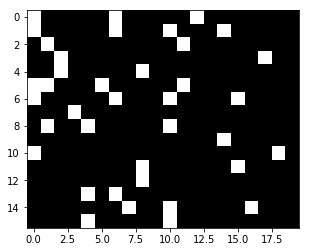

In [276]:
plt.gray()

plt.imshow(d[0][0])

In [56]:
N = d[0][0].shape[0]
N2 = d[0][0].shape[1]
gpu = -1
dimz = 100
batchsize = 16
epoch = 100
initmodel = ''
resume = ''
out = 'result'
is_test = False #'store_true'

In [57]:
print('GPU: {}'.format(gpu))
print('# dim z: {}'.format(dimz))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

GPU: -1
# dim z: 100
# Minibatch-size: 16
# epoch: 100



In [58]:
# Initialize / Resume
if initmodel:
    chainer.serializers.load_npz(initmodel, model)
if resume:
    chainer.serializers.load_npz(resume, optimizer)

In [59]:
train = list()
for i in range(len(d[0])-1):
#     idx = i % 100
    idx = i
    if d[1][idx] == False:
        train.append((d[0][idx].reshape(1, N, N2), d[0][idx+1].reshape(1, N, N2)))

In [60]:
len(train)

9000

In [61]:
n = 8000
test = train[n:]
train = train[:n]

In [277]:
# Prednetのtestデータと揃える
test_for_plot = list()
for i in range(len(d_test[0])):
    test_for_plot.append(d_test[0][i].reshape(1, N, N2))
test_for_plot_glider = list()
for i in range(len(d_glider[0])):
    test_for_plot_glider.append(d_glider[0][i].reshape(1, N, N2))

In [63]:
random.shuffle(train)
random.shuffle(test)

In [64]:
if is_test:
    train, _ = chainer.datasets.split_dataset(train, 100)
    test, _ = chainer.datasets.split_dataset(test, 100)
train_count = len(train)
test_count = len(test)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [65]:
model = net_conv.ConvAE_mini(input_size=N, input_size2=N2, n_filters=20, n_latent=dimz, filter_size=3, activation='relu')
# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [66]:
c = 1
while train_iter.epoch < epoch:
    sum_loss = 0
    batch = train_iter.next()
    x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
    x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
    x = chainer.Variable(x_array1)
    # Update model based on the loss function
    # defined by model.get_loss_func()
    optimizer.update(model.get_loss_func(), x, x_array2)
    sum_loss += float(model.loss.data) * len(x.data)
    if train_iter.is_new_epoch:
        print(c)
        c += 1
        print('train mean loss={}'.format(sum_loss / train_count))
        # evaluation
        sum_loss = 0
        for batch in test_iter:
            x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
            x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
            x = chainer.Variable(x_array1)
            loss_func = model.get_loss_func(k=10)
            loss_func(x, x_array2)
            sum_loss += float(model.loss.data) * len(x.data)
        test_iter.reset()
        print('test mean loss={}'.format(sum_loss / test_count))

1
train mean loss=0.03470445251464844
test mean loss=16.117757034301757
2
train mean loss=0.03304153442382812
test mean loss=13.175619880676269
3
train mean loss=0.03282184600830078
test mean loss=11.640680442810059
4
train mean loss=0.01426884651184082
test mean loss=10.470060119628906
5
train mean loss=0.028987207412719727
test mean loss=9.433026851654052
6
train mean loss=0.029801042556762695
test mean loss=8.549299987792969
7
train mean loss=0.013975221633911133
test mean loss=7.681295553207398
8
train mean loss=0.01647832489013672
test mean loss=6.903889587402344
9
train mean loss=0.01802654266357422
test mean loss=6.195808172225952
10
train mean loss=0.009586421966552735
test mean loss=5.526062135696411
11
train mean loss=0.008927136421203614
test mean loss=4.917553077697754
12
train mean loss=0.00937906551361084
test mean loss=4.330315700531006
13
train mean loss=0.010228879928588867
test mean loss=3.8238845739364624
14
train mean loss=0.008336231231689454
test mean loss=3.36964

In [75]:
# Note that os.makedirs(path, exist_ok=True) can be used
# if this script only supports python3
# if not os.path.exists(out):
#     os.mkdir(out)

# Save the model and the optimizer
print('save the model')
chainer.serializers.save_npz(os.path.join(out, 'model.model'), model)
print('save the optimizer')
chainer.serializers.save_npz(os.path.join(out, 'state.state'), optimizer)

save the model
save the optimizer


In [37]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi[0])
    fig.savefig(filename)

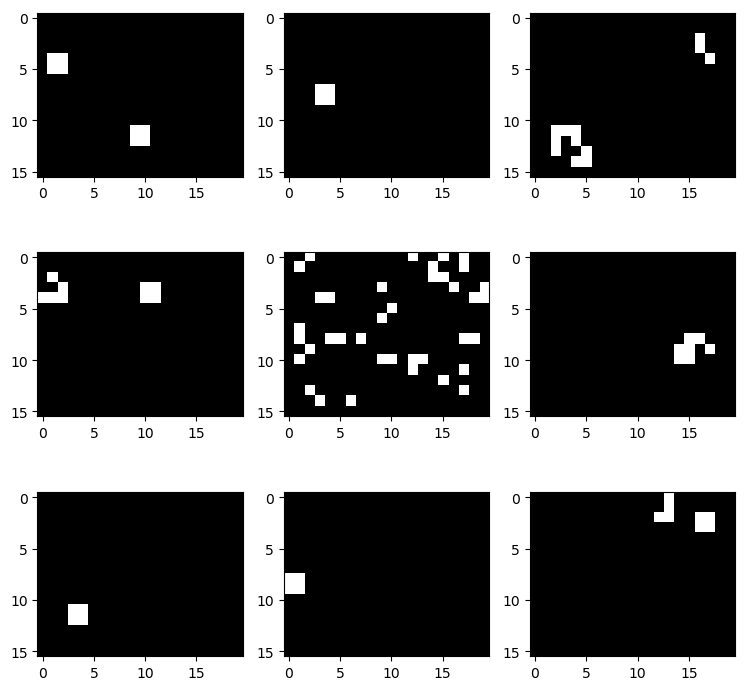

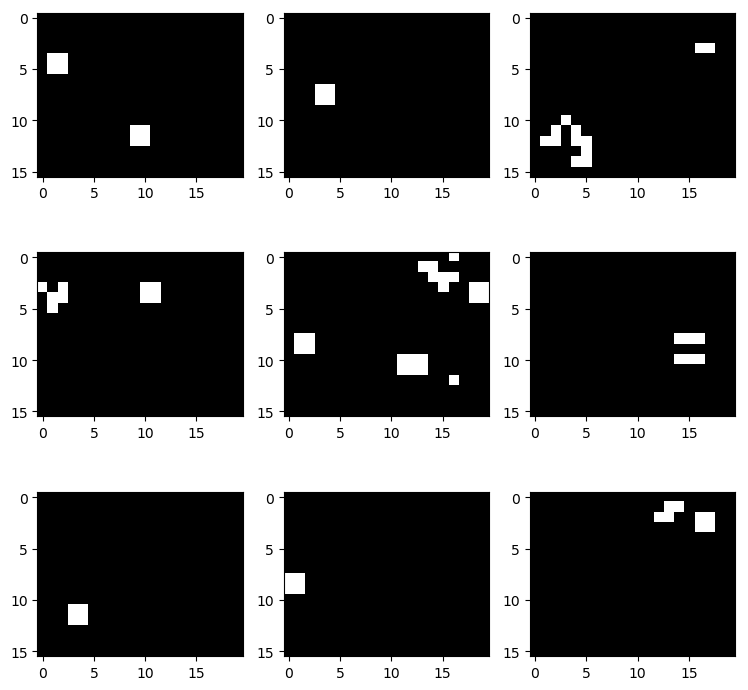

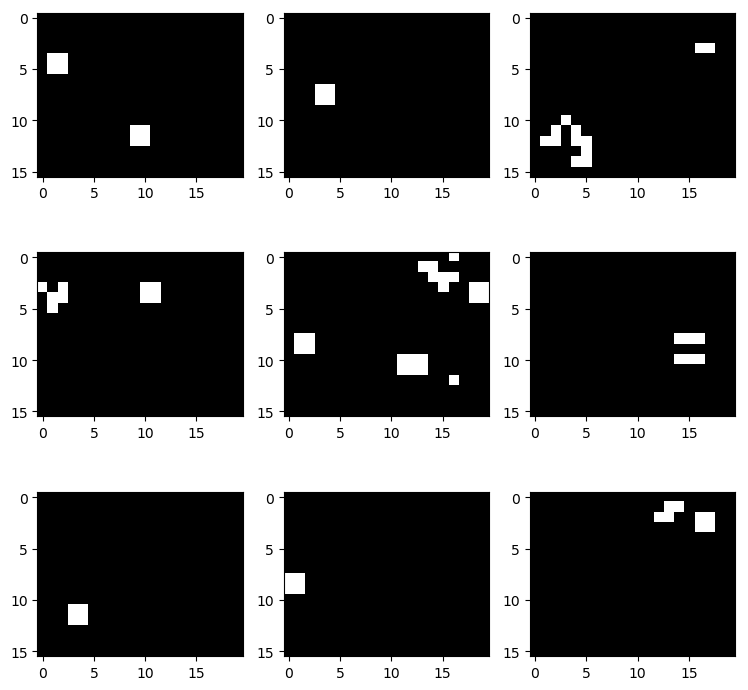

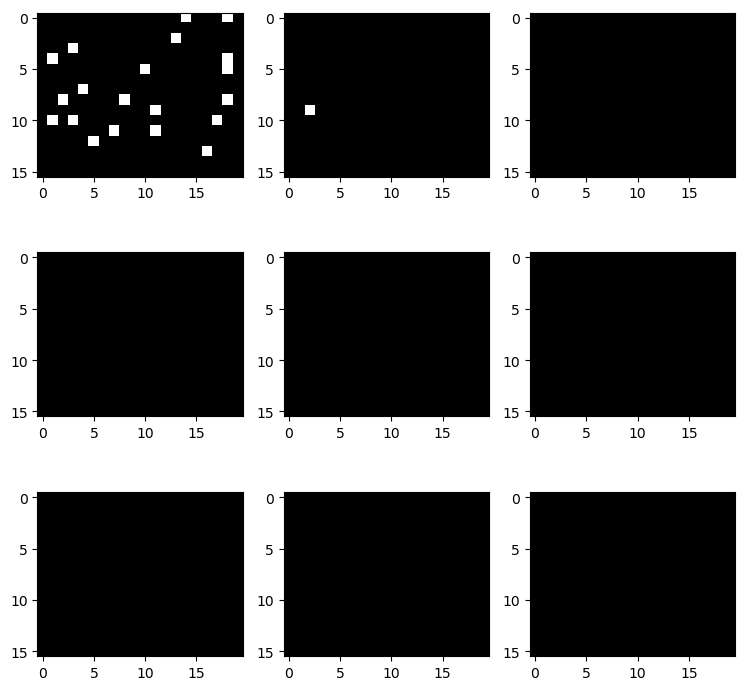

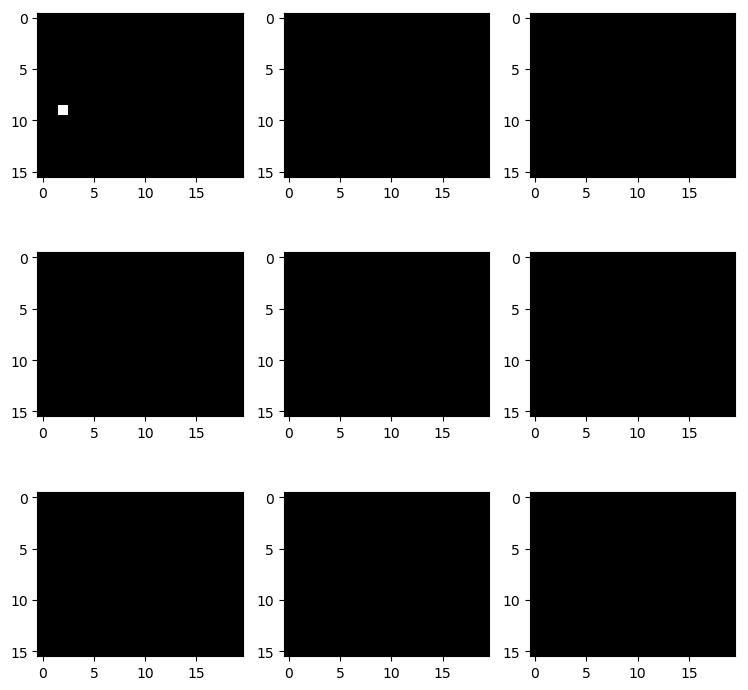

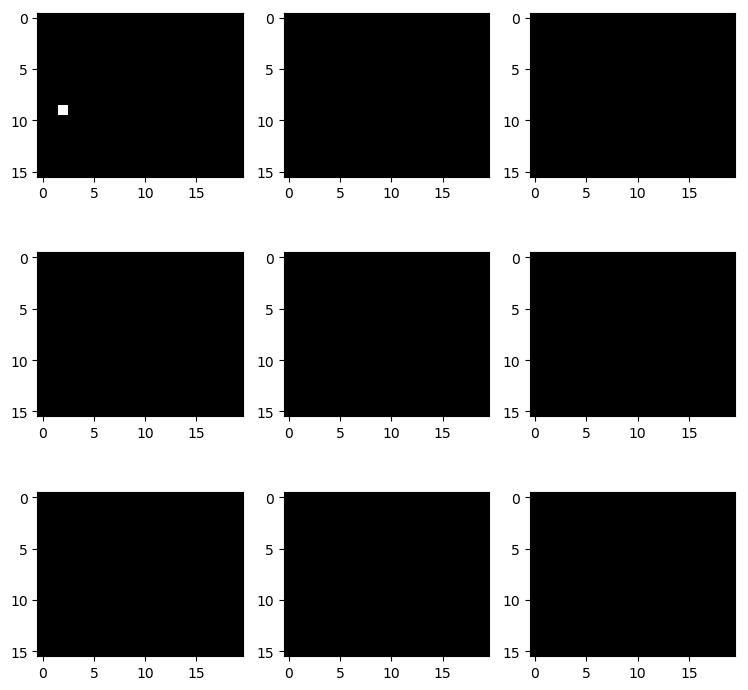

In [67]:
model.to_cpu()
train_ind = np.random.randint(0,len(train),9)
# train_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(train)[train_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'train_x'))
save_images(x_array2, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnextreconstructed'))

# test_ind = np.random.randint(0,len(test),9)
test_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(test_for_plot)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'test_x'))
save_images(x_array2, os.path.join(out, 'test_xnext'))
save_images(x1.data, os.path.join(out, 'test_xnextreconstructed'))


Can this model predict Glider? or not.

In [68]:
with open('../data/lifegame_data_glider.pickle', 'rb') as f:
    d2 = pickle.load(f)

d2[0] = np.array(list(map(lambda x: x.astype('float32'), d2[0])))

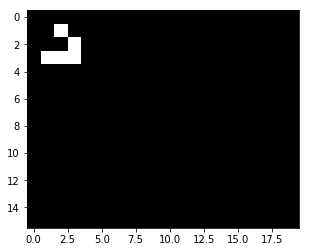

In [69]:
plt.gray()
plt.imshow(d2[0][0])

In [72]:
glider = list()
for i in range(len(d2[0])-1):
    idx = i
    if d2[1][idx] == False:
        glider.append((d2[0][idx].reshape(1, N, N2), d2[0][idx+1].reshape(1, N, N2)))

In [73]:
# Visualize the results
def save_images2(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(5, 5, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi[0])
    fig.savefig(filename)

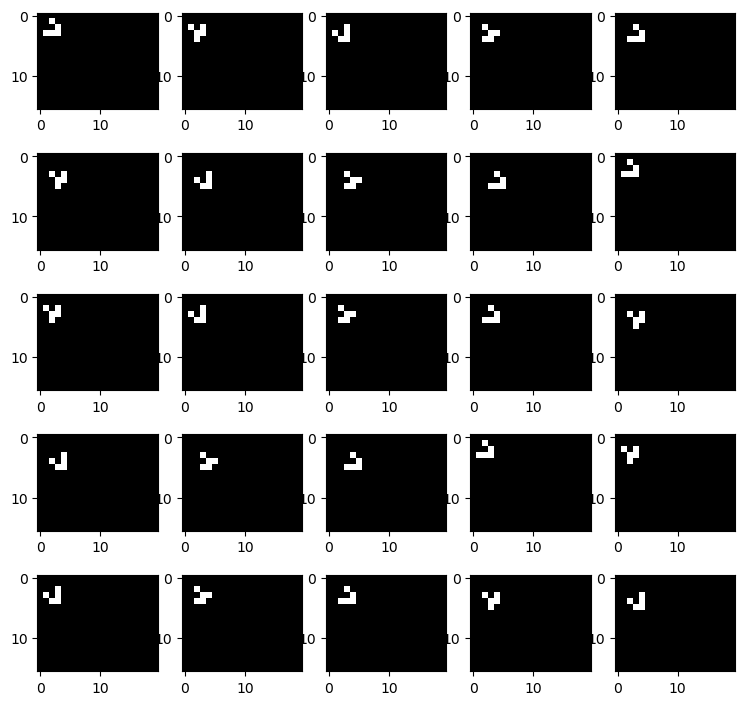

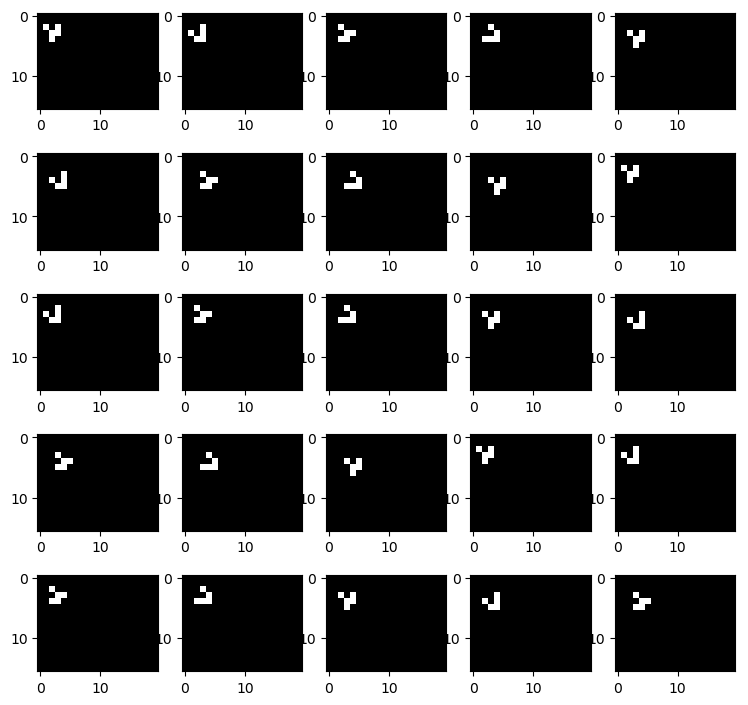

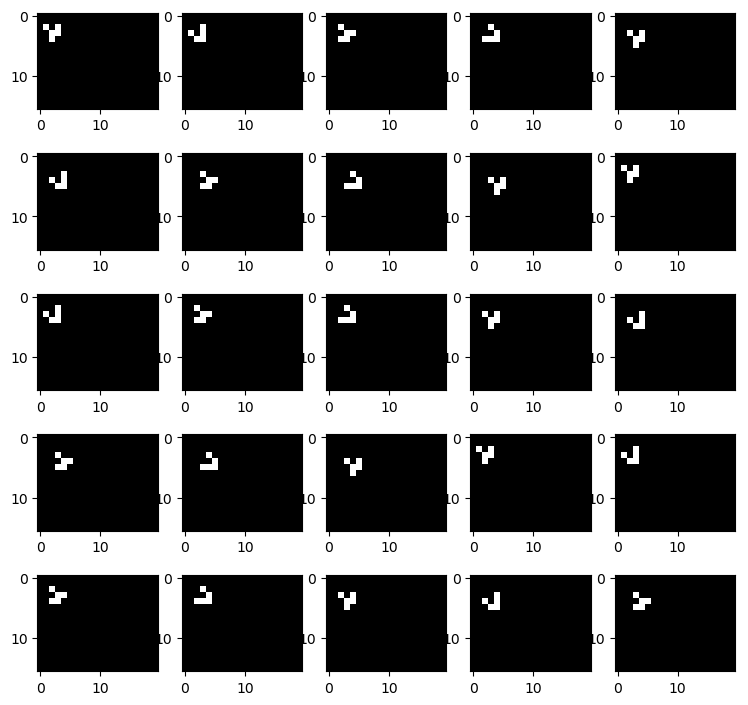

In [74]:
glider_ind = range(25)#[0,1,2,3,4,5,6,7,8]
batch = np.asarray(glider)[glider_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images2(x_array1, os.path.join(out, 'glider_x'))
save_images2(x_array2, os.path.join(out, 'glider_xnext'))
save_images2(x1.data, os.path.join(out, 'glider_xnextreconstructed'))


plot for paper (same format with Prednet)

In [159]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [171]:
with open('X_test.pickle', 'rb') as f:
    X_test2 = pickle.load(f)
with open('X_hat.pickle', 'rb') as f:
    X_hat2 = pickle.load(f)    

In [283]:
# test_ind = [0,1,2,3,4,5,6,7,8,9]
# test_ind = list(np.linspace(0, 99, 100, dtype='int32'))
# batch = np.asarray(test_for_plot)[test_ind]
test_ind = list(np.linspace(0, 9, 10, dtype='int32'))
batch = np.asarray(test_for_plot_glider)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x, batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

In [284]:
x_array1.data.shape

(10, 1, 16, 20)

In [287]:
X_test = x_array1.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 16, 20)
X_hat = x1.data.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 16, 20)
X_test = np.array(list(map(lambda x: x.repeat(8, axis=1).repeat(8, axis=2), X_test)))
X_hat = np.array(list(map(lambda x: x.repeat(8, axis=1).repeat(8, axis=2), X_hat)))

In [288]:
# plt.gray()
nt = 10
aspect_ratio = 0.8
# plt.figure(figsize = (nt, 2*aspect_ratio))
plt.figure(figsize = (100/7.2, 16/7.2))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = 'fig_for_paper/glider/'
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])

for i in plot_idx:
    for t in range(nt):     
        plt.subplot(gs[t])
        plt.imshow(cv2.cvtColor(X_test[i,t], cv2.COLOR_GRAY2RGB), interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        if t % 10 == 0:
            plt.imshow(X_hat2[0,0], interpolation='none')
        else:
            plt.imshow(cv2.cvtColor(X_hat[i,t-1], cv2.COLOR_GRAY2RGB), interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
    
    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
plt.close()